In [ ]:
%gui qt

# Visualizer sandbox

Getting the muselsl visualizer template to work with brainflow input.

In [ ]:
from pprint import pprint

import brainflow
from brainflow.board_shim import BoardShim, BoardIds

In [ ]:
board_id = BoardIds.MUSE_2_BOARD.value
board_desc = BoardShim.get_board_descr(board_id)
pprint(board_desc)

In [ ]:
BoardShim.get_current_board_data(board_id)

In [ ]:
import brainflow_viz_v2

In [ ]:
%run -i brainflow_viz_v2.py 

In [1]:
# Imports
import os, numpy as np,pandas as pd
import warnings
warnings.filterwarnings('ignore')
import eegnb
from eegnb import generate_save_fn
from eegnb.devices.eeg import EEG
from eegnb.experiments.visual_vep import vep
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.utils2 import load_data,plot_conditions, check_report
from eegnb.datasets import fetch_dataset

pygame 2.1.2 (SDL 2.0.18, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Here we can change the variables that we use for measuring experiments!

board_name = "muse2_bfn" # this can stay the same
experiment = "visual_vep" # this changes depending on the experiment, for the purposes of this notebook it can stay the same
subject_id = 1 # change this each time you have a new participant
session_nb = 1 # change this each time you have a new run
record_duration = 120 # this changes how long each session is

In [13]:
# Start EEG device
eeg_device = EEG(device=board_name, serial_num='Muse-B00E') # make sure to replace the serial_num with 'Muse-[your device's serial digits]'

# Create save file name
save_fn = generate_save_fn(board_name, experiment, subject_id, session_nb)
print(save_fn)

C:\Users\tchan3\.eegnb\data\visual_vep\local\muse2_bfn\subject0001\session001\recording_2023-01-13-21.32.10.csv


In [4]:
check_report(eeg_device)



Running signal quality check...
Accepting threshold stdev between: 1 - 18
running check (up to) 60 times, with 5-second windows
will stop after 2 good check results in a row



1/60

Signal quality:
   Fp1: √  (std:   5.1)
   Fp2: √  (std:   4.7)
  TP10: √  (std:  10.1)
   TP9: √  (std:   7.5)
No bad channels



2/60

Signal quality:
   Fp1: √  (std:   4.3)
   Fp2: √  (std:   4.2)
  TP10: √  (std:   9.0)
   TP9: √  (std:   6.6)
No bad channels



All good! You can proceed on to data collection :) 


In [14]:
vep.present(duration=record_duration, eeg=eeg_device, save_fn=save_fn)

377.9129 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [2048, 1152]. Using actual size
379.1271 	WARNING 	Use of rgb arguments to stimuli are deprecated. Please use color and colorSpace args instead


In [20]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    

# to load data from a specific subject and session:
subject = 1
session = 1
# make sure that these numbers are correct, or it will run from the last time you used 'subject' and 'session', 
# including from above!

raw = load_data(subject,session,
                experiment='visual_vep', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path)

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=39184
    Range : 0 ... 39183 =      0.000 ...   153.059 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=30712
    Range : 0 ... 30711 =      0.000 ...   119.965 secs
Ready.


In [21]:
raw.filter(1,15, method='iir')
# raw.plot_psd(fmin=1, fmax=30); # visualize power spectrum after filtering

# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'Left': 1, 'Right': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.4, baseline=(-0.1, 0),
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 15.00 Hz: -6.02, -6.02 dB

526 events found
Event IDs: [1 2]
sample drop %:  2.6615969581749055


Number of events,512
Events,Left: 257Right: 255
Time range,-0.102 – 0.398 sec
Baseline,-0.100 – 0.000 sec


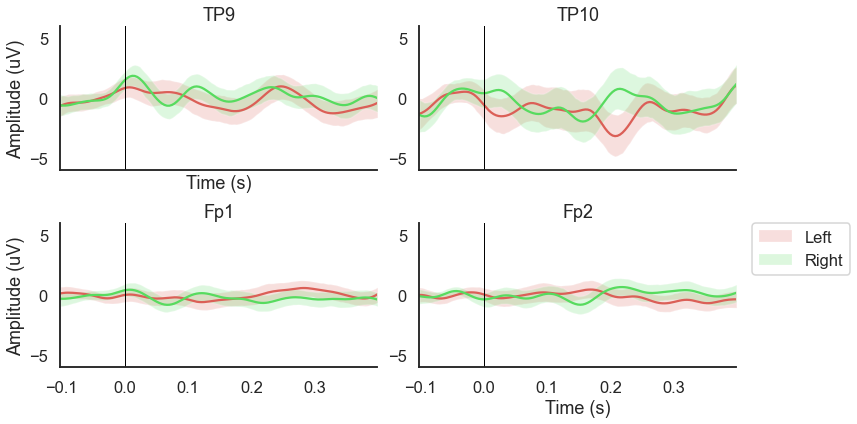

In [22]:
conditions = OrderedDict()
conditions['Left'] = [1]
conditions['Right'] = [2]

fig, ax = plot_conditions(epochs, conditions=conditions, 
                          ci=97.5, n_boot=1000, title='',
                          channel_order=[0,1,3,2],
                          diff_waveform=None)